In [47]:
import argparse
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import pandas as pd

from dataset import get_dataloader
from tqdm import tqdm
import random
from models.gated_tpp import *
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

def triggering_kernel(t,n_kernel = 0):
    
    if n_kernel ==0:
        return 0.2*(0.5+t)**(-1.3)
    elif n_kernel ==1:
        return 0.03*np.exp(-0.3*t)
    elif n_kernel ==2:
        return 0.05*np.exp(-0.2*t) + 0.16*np.exp(-0.8*t)
    else:
        t_c = np.copy(t)
        t_c[t_c>4] =0
        sin = np.sin(t_c)/8
        sin[sin <0] =0
        return sin


In [2]:
def power_law_kernel(t):  
    
    return 0.2 * (0.5 + t)**(-1.3)



def sin_kernel(t):
    

    t_c = np.copy(t)
    t_c[t_c>4] =0
    sin = np.sin(t_c)/8
    sin[sin <0] =0
    return sin

def sin_kernel_2(t):
    

    t_c = np.copy(t)
    t_c[t_c>15] =0
    sin = np.sin(0.3*t_c)/9
    sin[sin <0] =0
    return sin




def squared_exponential_kernel(x, sigma=1, lengthscale=1, norm=1):

    return (sigma ** 2) * torch.exp(-(x ** 2) / lengthscale ** 2)

def exponential_kernel(x, sigma=1, lengthscale=1, norm=1):

    return (sigma ** 2) * torch.exp(-x/ lengthscale )


def rayleigh_kernel(x, omega=1, s=1, norm=1):

    return (omega *x) * torch.exp(-(omega*x)/s**2)



def polynomial_kernel(x1,x2, sigma=0, p=2):    
    
    return ((x1*x2).sum(-1) +sigma)**p

def rational_quadratic_kernel(x, sigma =1, alpha= 0.1, lengthscale = 0.01,norm = 1):
#     d = x ** norm
    d =x
    return (sigma ** 2) *(1+((d**2)/(alpha*lengthscale)))**(-alpha)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =2):
    d = x**norm
    return 1+torch.tanh((d-l)/s)

def power_law_kernel(t):  
    
    return 0.2 * (0.5 + t)**(-1.3)

def sin_kernel(t):
    

    t_c = np.copy(t)
    t_c[t_c>4] =0
    sin = np.sin(t_c)/8
    sin[sin <0] =0
    return sin


def get_moving_average(times,scores,step = 0.15,t_max = 200):
    
    t = []
    alpha = []
    
    index= 0
    for i in np.arange(step,t_max,step):
        avg_index = (times<i) & ( times >i - step)
        t.append(times[avg_index].mean().item())
        alpha.append(scores[avg_index].mean().item())
    
    zero_avg_index = times ==0
    t.insert(0,times[zero_avg_index].mean().item())
    alpha.insert(0,scores[zero_avg_index].mean().item())
    
    
    return np.array(t),np.array(alpha) 


def get_triggering_kernel_values(model,device ='cpu',score_type = 'final'):
    
    encoder = model.encoder.to(device)

    normalized_event_time = torch.arange(0,200,0.1).unsqueeze(0).to(device)
    event_type = torch.ones(normalized_event_time.size(-1)).long().unsqueeze(0).to(device)

    type_embedding = encoder.type_emb(event_type) * math.sqrt(model.d_model)

    subsequent_mask = get_subsequent_mask(event_type)

    xt_bar = normalized_event_time.unsqueeze(1). \
        expand(normalized_event_time.size(0), normalized_event_time.size(1), normalized_event_time.size(1))
    xt = xt_bar.transpose(1, 2)


    xd_bar = type_embedding.unsqueeze(1).expand(type_embedding.size(
        0), type_embedding.size(1), type_embedding.size(1), type_embedding.size(-1))
    xd = xd_bar.transpose(1, 2)

    kernel_scores = encoder.kernel((xt, xt_bar), (xd, xd_bar))
#     sigmoid_scores = encoder.sigmoid((xt, xt_bar), (xd, xd_bar))
    
    if score_type =='kernel_only' :
        scores = kernel_scores
    elif score_type == 'sigmoid_only':
        scores = sigmoid_scores   
    else:
        scores = kernel_scores*sigmoid_scores                               

    length = event_type.sum()
    t_diff = torch.abs(xt - xt_bar)


    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]

    x = times.detach()
    y = triggering_values.detach()

    sorted_indices = torch.argsort(x)

    x = x[sorted_indices]
    y = y[sorted_indices]
    
    return x,y



def plot_triggering_kernel_vs_actual_kernels(model,kernel_function,device = 'cpu',step = 0.25,
                                             score_type = 'final' ,t_max = 200,axes = None):
    
    
    times, scores = get_triggering_kernel_values(model,device = 'cpu',score_type = score_type)
    t,alpha = get_moving_average(times,scores,step = step,t_max = t_max)

    
    alpha = (alpha - alpha.min())/(alpha.max()-alpha.min())
    actual_alpha = kernel_function(np.array(t))
    actual_alpha = (actual_alpha - actual_alpha.min())/(actual_alpha.max()-actual_alpha.min())
    
    
    
    if axes is None:
        fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))
        axes = (ax1, ax2,ax3)
    else:
        axes = axes
    
    score_type_titles = {'final':'Estimated Gated Kernel','kernel_only':'Estimated Kernel','sigmoid_only':'Estimated Gate'}

    axes[0].plot(t,alpha,label=score_type_titles[score_type])
    if score_type !='sigmoid_only':
        axes[0].plot(t,actual_alpha,label='Actual Kernel')
    axes[0].set_xlim(0, 200)
    axes[0].legend()

    axes[1].plot(t,alpha,label=score_type_titles[score_type])
    if score_type !='sigmoid_only':
        axes[1].plot(t,actual_alpha,label='Actual Kernel')
    axes[1].set_xlim(0, 10)
    axes[1].legend()


    axes[2].plot(t,alpha,label=score_type_titles[score_type])
    if score_type !='sigmoid_only':
        axes[2].plot(t,actual_alpha,label='Actual Kernel')
    axes[2].set_xlim(0, 5)
    axes[2].legend()

    plt.show()
    

data = '../data/simulated/power_hawkes/'
batch_size = 1


def load_data(name, dict_name):
    with open(name, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
        num_types = data['dim_process']
        data = data[dict_name]
        return data, int(num_types)


## Comparing Embedding Scores vs Time Scores

### Time Shifted Positional Embedding

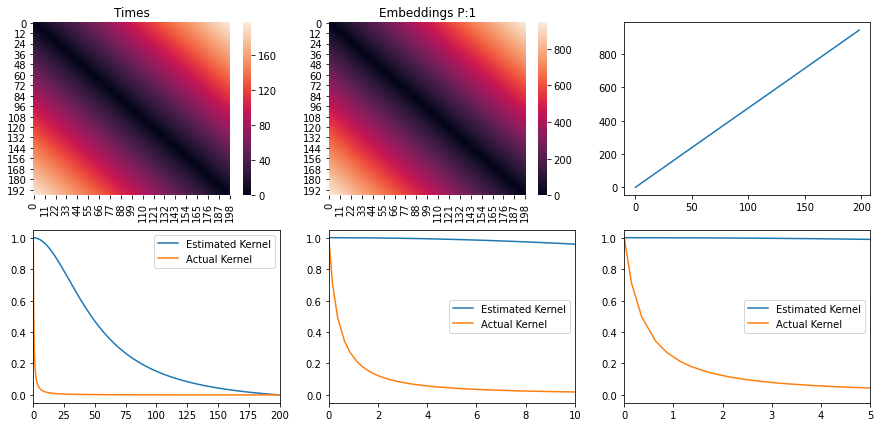

In [52]:



train_data, num_types = load_data(data + 'train.pkl', 'train')
dev_data, _ = load_data(data + 'dev.pkl', 'dev')
test_data, _ = load_data(data + 'test.pkl', 'test')


trainloader = get_dataloader(train_data, batch_size, shuffle=True)
testloader = get_dataloader(test_data,1, shuffle=False)
valloader = get_dataloader(dev_data, 1, shuffle=False)


model = gated_tpp(num_types,128,4,dropout= 0.1,alpha = 0.99,kernel_type='rational_quadratic',length_scale=50,timetovec=True)
device = 'cuda'
model.load_state_dict(torch.load('trained_models/20210927_172312.pt'))



event_time = torch.arange(1,200,1.0).unsqueeze(0)
event_type = torch.zeros(199).unsqueeze(0)
temp_enc = model.encoder.embedding(event_type,event_time)

normalized_event_time = event_time
xt_bar = normalized_event_time.unsqueeze(1). \
    expand(normalized_event_time.size(0), normalized_event_time.size(1), normalized_event_time.size(1))
xt = xt_bar.transpose(1, 2)
d = torch.abs(xt - xt_bar)**1



p = 1
xd_bar = temp_enc.unsqueeze(1).expand(temp_enc.size(
    0), temp_enc.size(1), temp_enc.size(1), temp_enc.size(-1))
xd = xd_bar.transpose(1, 2)
ed = torch.abs(xd - xd_bar)
# s = ((ed**p).sum(-1)**(1/p)).detach()

s = (ed).sum(-1).detach()
# s = (xd*xd_bar).sum(-1)


fig, axes = plt.subplots(2,3,figsize=(15,7))
axes = axes.flatten()
sns.heatmap(torch.abs(d[0]), annot=False,fmt="d",ax = axes[0]).set_title('Times')
sns.heatmap(torch.abs(s[0]), annot=False,ax = axes[1]).set_title('Embeddings' + ' P:'+(str(p)))
axes[2].plot(d[0][-1],s[0][-1])
plot_triggering_kernel_vs_actual_kernels(model,power_law_kernel,device = 'cpu',step = 0.25,score_type='kernel_only',axes =axes[3:]  )

plt.show()

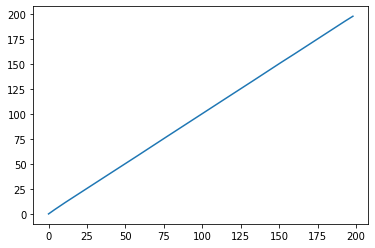

In [6]:
s = (ed).sum(-1).detach()
plt.plot(d[0][-1],s[0][-1])


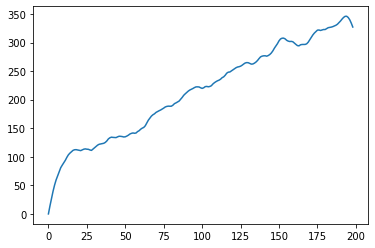

In [ ]:



train_data, num_types = load_data(data + 'train.pkl', 'train')
dev_data, _ = load_data(data + 'dev.pkl', 'dev')
test_data, _ = load_data(data + 'test.pkl', 'test')


trainloader = get_dataloader(train_data, batch_size, shuffle=True)
testloader = get_dataloader(test_data,1, shuffle=False)
valloader = get_dataloader(dev_data, 1, shuffle=False)

t_max = max(max(max(valloader.dataset.time)), max(max(testloader.dataset.time)), max(max(trainloader.dataset.time)))
t_max = 1
model = gated_tpp(num_types,128,256,dropout= 0.1,alpha = 1,kernel_type='rational_quadratic',length_scale=5,timetovec=True)
device = 'cuda'
model.load_state_dict(torch.load('trained_models/20210922_001836.pt'))



event_time = torch.arange(1,200,1.0).unsqueeze(0)
event_type = torch.zeros(199).unsqueeze(0)
temp_enc = model.encoder.embedding(event_type,event_time)

normalized_event_time = event_time
xt_bar = normalized_event_time.unsqueeze(1). \
    expand(normalized_event_time.size(0), normalized_event_time.size(1), normalized_event_time.size(1))
xt = xt_bar.transpose(1, 2)
d = torch.abs(xt - xt_bar)**1



p = 1
xd_bar = temp_enc.unsqueeze(1).expand(temp_enc.size(
    0), temp_enc.size(1), temp_enc.size(1), temp_enc.size(-1))
xd = xd_bar.transpose(1, 2)
ed = torch.abs(xd - xd_bar)
# s = ((ed**p).sum(-1)**(1/p)).detach()

s = ((ed).sum(-1)**(1/p)).detach()
# s = (xd*xd_bar).sum(-1)


fig, axes = plt.subplots(2,3,figsize=(15,7))
axes = axes.flatten()
sns.heatmap(torch.abs(d[0]), annot=False,fmt="d",ax = axes[0]).set_title('Times')
sns.heatmap(torch.abs(s[0]), annot=False,ax = axes[1]).set_title('Embeddings' + ' P:'+(str(p)))
axes[2].plot(d[0][-1],s[0][-1])
plot_triggering_kernel_vs_actual_kernels(model,power_law_kernel,device = 'cpu',step = 0.25,score_type='kernel_only',axes =axes[3:]  )

plt.show()

## Replicating Power Law Kernel

In [ ]:
Lengthscale:0.437743
Sigma:0.390046
Base_intensity:0.188688

tensor(8.7951)

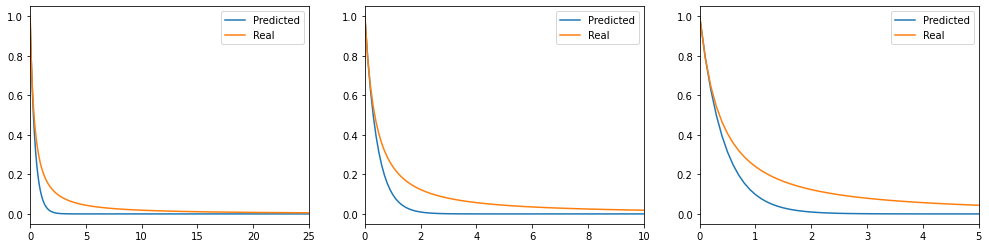

In [315]:
t = torch.arange(0,200,0.1)

values = rational_quadratic_kernel(t,sigma= 0.4, lengthscale = 1.141700)
# values = (values - values.min())/(values.max()-values.min())
real_values = power_law_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

fig, axes = plt.subplots(1, 3,figsize=(17,4))


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 25)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 5)
torch.abs(values -real_values).sum()

tensor(0.7470)

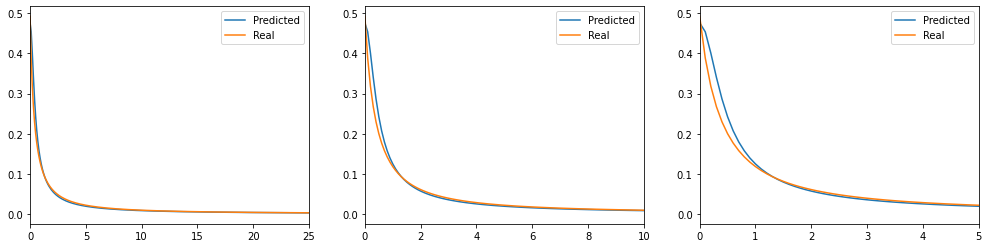

In [301]:
t = torch.arange(0,200,0.1)

values = rational_quadratic_kernel(t,sigma= 0.69, lengthscale = 0.2, alpha = 0.6)
# values = (values - values.min())/(values.max()-values.min())
real_values = power_law_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

fig, axes = plt.subplots(1, 3,figsize=(17,4))


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 25)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 5)
torch.abs(values -real_values).sum()

tensor(6.0775)

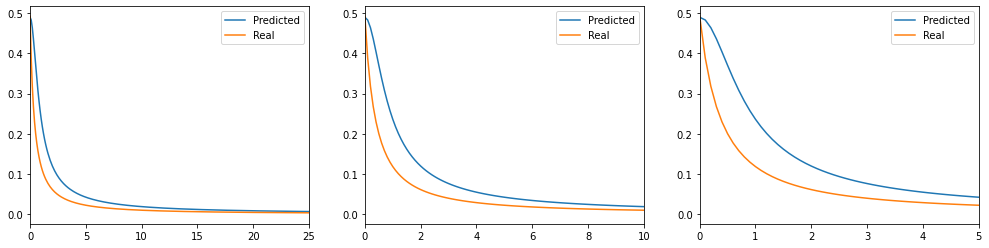

In [293]:
t = torch.arange(0,200,0.1)

values = rational_quadratic_kernel(t,sigma= 0.7, lengthscale = 0.7, alpha = 0.6)
# values = (values - values.min())/(values.max()-values.min())
real_values = power_law_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

fig, axes = plt.subplots(1, 3,figsize=(17,4))


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 25)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 5)
torch.abs(values -real_values).sum()

tensor(0.7542)

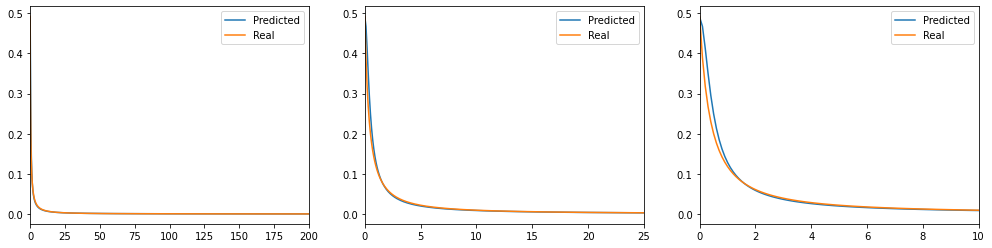

In [87]:
values = rational_quadratic_kernel(t,sigma= 0.7, lengthscale = 0.2, alpha = 0.6)
# values = (values - values.min())/(values.max()-values.min())

real_values = power_law_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

fig, axes = plt.subplots(1, 3,figsize=(17,4))


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 200)
axes[1].set_xlim(0, 25)
axes[2].set_xlim(0, 10)
torch.abs(values -real_values).sum()

tensor(10.9318)

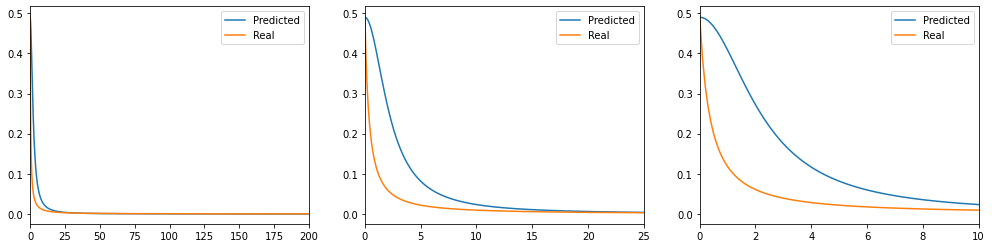

In [89]:
values = rational_quadratic_kernel(t,sigma= 0.7, lengthscale = 5, alpha = 1.0)
# values = (values - values.min())/(values.max()-values.min())

real_values = power_law_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

fig, axes = plt.subplots(1, 3,figsize=(17,4))


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 200)
axes[1].set_xlim(0, 25)
axes[2].set_xlim(0, 10)
torch.abs(values -real_values).sum()

## Replicating Sinusoid Kernel

tensor(1.6775)

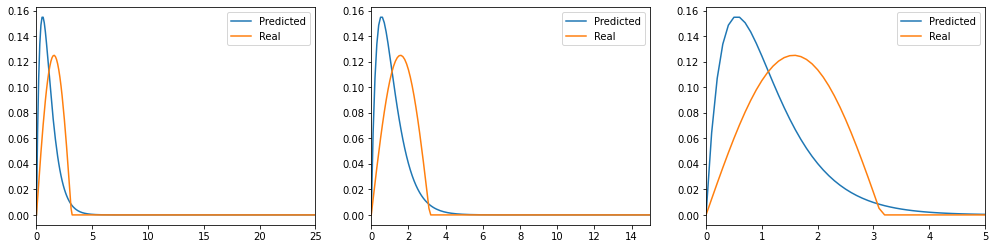

In [403]:
t = torch.arange(0,200,0.1)

values = rayleigh_kernel(t,omega= 0.77, s =  0.65)
# values = (values - values.min())/(values.max()-values.min())
real_values = sin_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

fig, axes = plt.subplots(1, 3,figsize=(17,4))


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 25)
axes[1].set_xlim(0, 15)
axes[2].set_xlim(0, 5)
torch.abs(values -real_values).sum()

tensor(1.6670)

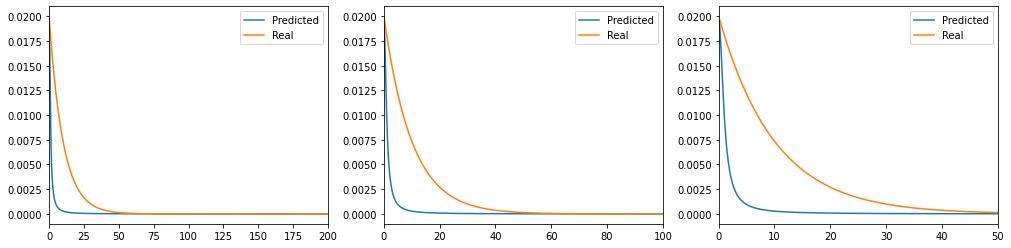

In [95]:
t = torch.arange(0,200,0.1)

values = rational_quadratic_kernel(t,sigma= 0.14, lengthscale =  1.0 , alpha = 0.9)
# values = (values - values.min())/(values.max()-values.min())
real_values = exponential_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

fig, axes = plt.subplots(1, 3,figsize=(17,4))


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 200)
axes[1].set_xlim(0, 100)
axes[2].set_xlim(0, 50)
torch.abs(values -real_values).sum()

tensor(2.4705)

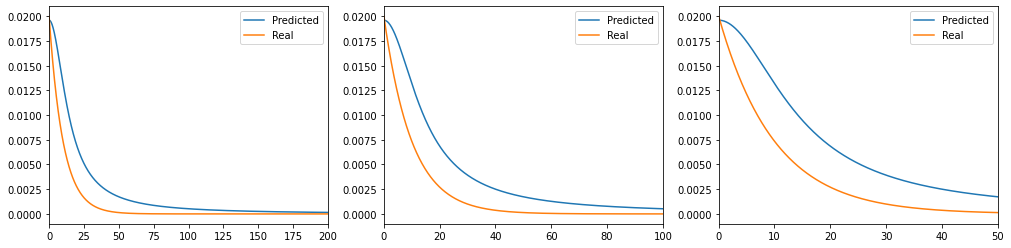

In [97]:
t = torch.arange(0,200,0.1)

values = rational_quadratic_kernel(t,sigma= 0.14, lengthscale =  201.0 , alpha = 0.9)
# values = (values - values.min())/(values.max()-values.min())
real_values = exponential_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

fig, axes = plt.subplots(1, 3,figsize=(17,4))


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 200)
axes[1].set_xlim(0, 100)
axes[2].set_xlim(0, 50)
torch.abs(values -real_values).sum()

tensor(39.5698)

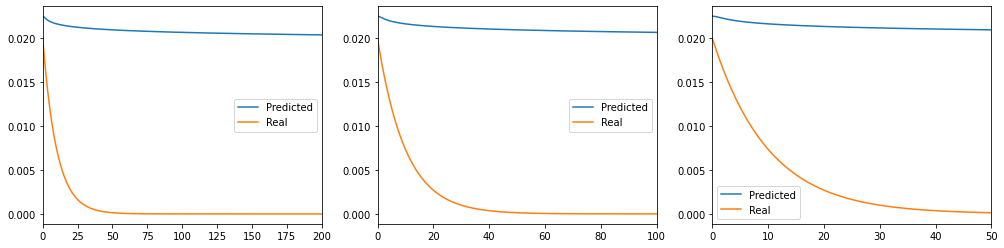

In [100]:
t = torch.arange(0,200,0.1)

values = rational_quadratic_kernel(t,sigma= 0.15, lengthscale =  200 , alpha = 0.01)
# values = (values - values.min())/(values.max()-values.min())
real_values = exponential_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

fig, axes = plt.subplots(1, 3,figsize=(17,4))


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 200)
axes[1].set_xlim(0, 100)
axes[2].set_xlim(0, 50)
torch.abs(values -real_values).sum()

(0.0, 5.0)

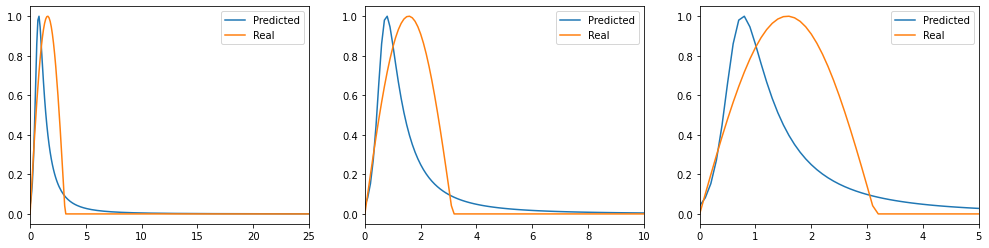

In [708]:
def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =1):
    d = x**norm
    return 1 + torch.tanh((d - l) / s)

t =torch.arange(0,200,0.1)
val = rational_quadratic_kernel(t,sigma= 1.0, lengthscale = 0.6, alpha = 1.3)
val_s = sigmoid((t),l =0.58,s= 0.28,norm =1)
values = val_s*val

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = sin_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 25)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 5)


## Replicating Power Hawkes with Gating


tensor(2.0351)

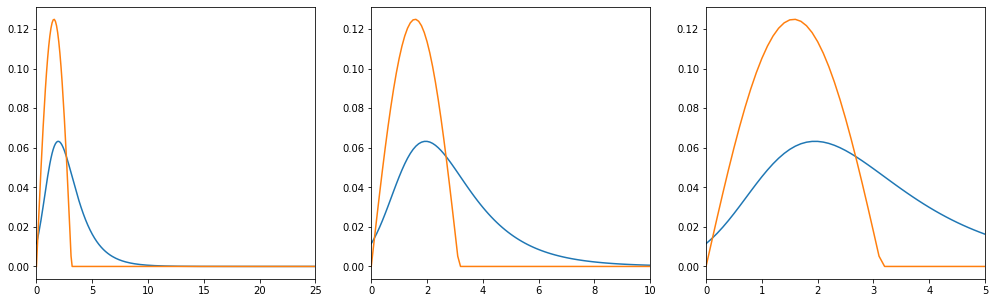

In [905]:
t =torch.arange(0,200,0.1)+0.000001


def magic_kernel(x, sigma=1, lengthscale=1, alpha = 1.0):
    d = x

    return sigma * torch.exp(-d / lengthscale) * ((1 + torch.exp(-d)) ** -alpha)



def test_kernel(t,alpha=1,l=1):
    
    return (alpha/l)*torch.exp(-t/l)*(1+torch.exp(-t/l))**(-1-alpha)
    
    

# values = magic_kernel(t, lengthscale = 2.8      , alpha =    1.5 )
values = magic_kernel(t,sigma =0.473772705,lengthscale = 1.5,alpha =5.361608505)
# values = (values - values.min())/(values.max()-values.min())

real_values = sin_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,5))
axes = axes.flatten()
for ax in axes:
    ax.plot(t,values)
    ax.plot(t,real_values)
    
axes[0].set_xlim(0, 25)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 5)
torch.abs(values - real_values).sum()

In [96]:
t

tensor([1.0000e-06, 1.0000e-01, 2.0000e-01,  ..., 1.9970e+02, 1.9980e+02,
        1.9990e+02])

## Replicating 2-D Hawkes with Gating

In [222]:
def magic_kernel_2(x, sigma=1, lengthscale=1, l = 1.0,s=1.0):
    d = x
    k1 = 1 + torch.tanh((d - l +1) / s)
    k2 = torch.exp(-(d) / lengthscale)
  
    return sigma*k1*k2


t =torch.arange(0,200,0.1)+0.000001

def triggering_kernel(t,n_kernel = 0):
    
    if n_kernel ==0:
        return 0.2*(0.5+t)**(-1.3)
    elif n_kernel ==2:
        return 0.03*np.exp(-0.3*t)
    elif n_kernel ==1:
        return 0.05*np.exp(-0.2*t) + 0.16*np.exp(-0.8*t)
    else:
        t_c = np.copy(t)
        t_c[t_c>4] =0
        sin = np.sin(t_c)/8
        sin[sin <0] =0
        return sin


In [365]:
 def magic_kernel_2(x, sigma=1, lengthscale=5, l = 1.0,s=1.0):
    d= x
    k1 = (1 + torch.tanh((d - l) / s))
    alpha = 1
    k2 =  (1 + (d ** 2) / (alpha * lengthscale ** 2)) ** (-alpha)
    # k2 = torch.exp(-(d) / lengthscale)
    scores = (sigma**2)*(k1)*(k2)
  
    return scores   

 def magic_kernel_1(x, sigma=1, lengthscale=5, alpha=1):
    d= x
    k1 = (1 + torch.exp(-d))**(-alpha*2)
    k2 = torch.exp(-(d) / lengthscale)
    scores = (sigma)*(k1)*(k2)
  
    return scores   

In [400]:
params = pd.read_csv('learned_params_2.csv')
params.tail(4)

,Model_ID,L11,L21,L12,L22,Sigma 11,Sigma 21,Sigma 12,Sigma 21.1,Lengthscale11,Lengthscale12,Lengthscale21,Lengthscale22,s11,s12,s21,s22,beta_1,beta_2,beta_3
74,2a19e9b853,0.579650,0.404747,0.316782,0.212491,0.147831,0.235307,0.054165,0.092213,2.087715,2.404692,1.426176,1.706437,1.0,1.0,1.0,NaN,NaN,NaN,NaN
75,e0120be7e3,0.640149,0.591093,0.543401,0.500024,0.049465,0.090392,0.017631,0.033137,2.893737,3.780532,2.611288,3.486771,1.0,1.0,1.0,NaN,NaN,NaN,NaN
76,eba0893fb2,0.571892,0.403248,0.300324,0.203333,0.221997,0.351827,0.082681,0.146364,2.006597,2.360444,1.326807,1.634544,1.0,1.0,1.0,NaN,NaN,NaN,NaN
77,d34073a286,0.636431,0.552886,0.495161,0.426366,0.205370,0.396706,0.035529,0.085694,2.499711,3.337269,2.968652,3.825025,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [ ]:
[params.Model_ID ==model_id].values[0]

(0.0, 10.0)

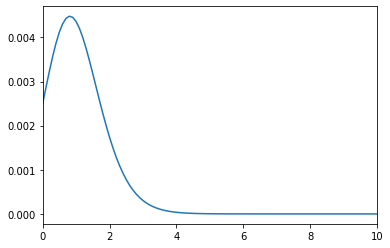

In [404]:
i =3
values = magic_kernel_1(t,sigma = 0.5, lengthscale = 0.426366, alpha = 3.825025)
plt.plot(t,values)
plt.xlim(0,10)

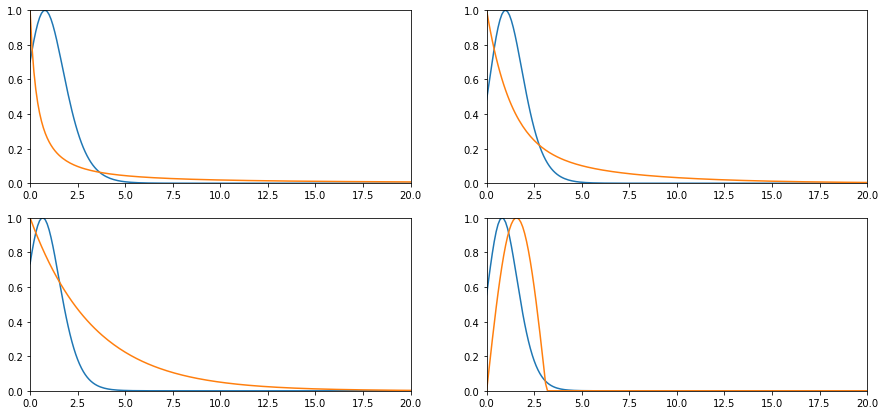

In [405]:


model_id  = 'd34073a286'
lengtscales = params.loc[params.Model_ID ==model_id].values[0][1:5]
sigmas = params.loc[params.Model_ID ==model_id].values[0][5:9]
alphas = params.loc[params.Model_ID ==model_id].values[0][9:13]
# ss = params.loc[params.Model_ID ==model_id].values[0][13:17]

t =torch.arange(0,200,0.1)+0.000001


fig, axes = plt.subplots(2, 2,figsize=(15,7))
axes = axes.flatten()
for i in range(len(axes)):

    values = magic_kernel_1(t,sigma = sigmas[i], lengthscale = lengtscales[i], alpha = alphas[i])
    values = (values - values.min())/(values.max()-values.min())
    real_values = triggering_kernel(t,i)
    real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

    axes[i].plot(t,values)
    axes[i].plot(t,real_values)
    axes[i].set_xlim(0, 20)
    axes[i].set_ylim(0, 1)       
# axes[0].set_xlim(0, 10)
# axes[1].set_ylim(0, 0.2)
# axes[2].set_xlim(0, 10)
# axes[3].set_ylim(0, 0.3)


TypeError: magic_kernel_2() got an unexpected keyword argument 's'

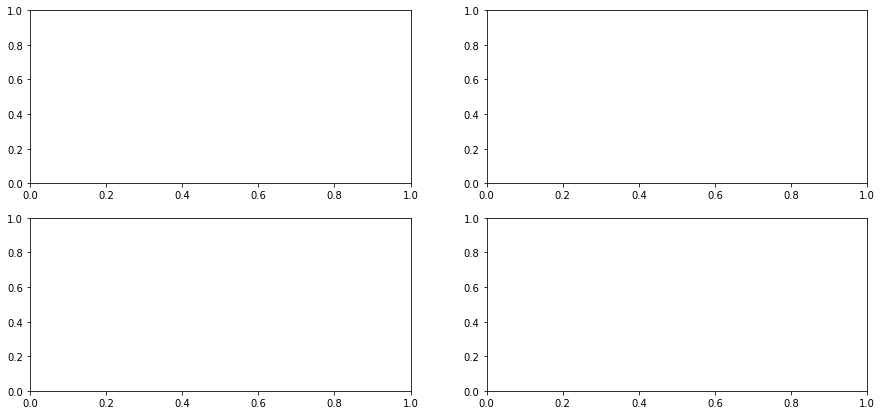

In [361]:


model_id  = '7d12e2410c'
ls = params.loc[params.Model_ID ==model_id].values[0][1:5]
sigmas = params.loc[params.Model_ID ==model_id].values[0][5:9]
lengtscales = params.loc[params.Model_ID ==model_id].values[0][9:13]
ss = params.loc[params.Model_ID ==model_id].values[0][13:17]

t =torch.arange(0,200,0.1)+0.000001


def magic_kernel_2(x, sigma=1, lengthscale=5, alpha = 1):
    
    d = x
    k1 = (1 + torch.exp(-d))**(-alpha*2)


    # k2 =  (1 + (d ** 2) / (alpha * lengthscale ** 2)) ** (-alpha)
    k2 = torch.exp(-(d) / lengthscale)
    scores = (sigma)*(k1)*(k2)
    return scores

fig, axes = plt.subplots(2, 2,figsize=(15,7))
axes = axes.flatten()
for i in range(len(axes)):

    values = magic_kernel_2(t,sigma = sigmas[i], lengthscale = lengtscales[i], l = ls[i])
#     values = (values - values.min())/(values.max()-values.min())
    real_values = triggering_kernel(t,i)
#     real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

    axes[i].plot(t,values)
    axes[i].plot(t,real_values)
    axes[i].set_xlim(0, 10)
    axes[i].set_ylim(0, 1)       
# axes[0].set_xlim(0, 10)
# axes[1].set_ylim(0, 0.2)
# axes[2].set_xlim(0, 10)
# axes[3].set_ylim(0, 0.3)


In [331]:
values = magic_kernel_2(t,sigma = sigmas[i], lengthscale = lengtscales[i], s = ss[i],l = ls[i])
#     values = (values - values.min())/(values.max()-values.min())
real_values = triggering_kernel(t,i)
fig, axes = plt.subplots(2, 2,figsize=(15,7))


In [21]:
real_values

array([1.2500000e-07, 1.2479302e-02, 2.4833789e-02, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

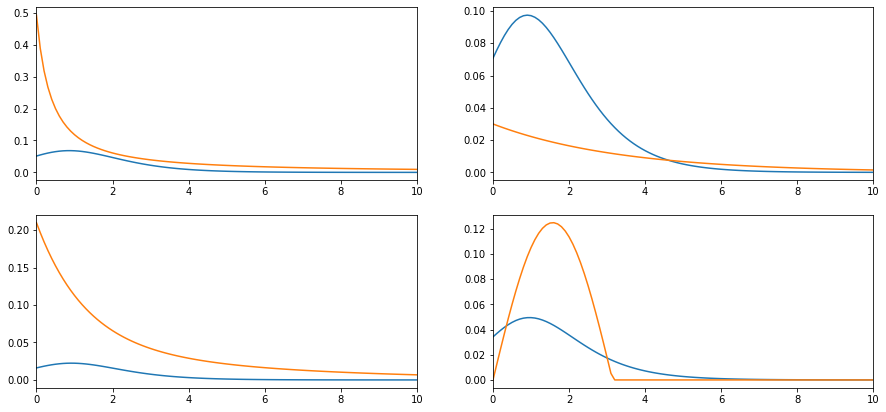

In [885]:
model_id  = 'd03698576c'
# lengtscales = params.loc[params.Model_ID ==model_id].values[0][1:5]

lengtscales = [1,1,1,1]

sigmas = params.loc[params.Model_ID ==model_id].values[0][5:9]
alphas = params.loc[params.Model_ID ==model_id].values[0][9:13]

def magic_kernel(x, sigma=1, lengthscale=1, alpha = 1.0):
    d = x

    return sigma * torch.exp(-d / lengthscale) * ((1 + torch.exp(-d)) ** -alpha)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =1):
    d = x**norm
    return b+torch.tanh((d-l)/s)



t =torch.arange(0,200,0.1)+0.000001
# val = magic_kernel(t,sigma= 3.4, lengthscale = 2.77, alpha = 2.770443439)
# val = magic_kernel(t,sigma= 1.7, lengthscale = 1.6, alpha = 3.8)
# val = magic_kernel(t,sigma= 3.4, lengthscale = 0.27, alpha = 1.2)
# val = magic_kernel(t,sigma= 0.26, lengthscale = 0.66, alpha = 0.06)

# val = magic_kernel(t,sigma= 0.8, lengthscale = 0.8, alpha = 0.6)
val = magic_kernel(t,sigma= 3.365638971, lengthscale = 4.381412029, alpha = 4.601394653)
# val = magic_kernel(t,sigma= 3.4, lengthscale = 0.27, alpha = 1.2)
# val = magic_kernel(t,sigma= 0.26, lengthscale = 0.66, alpha = 0.06)


# val_s = sigmoid((t),l =1.0,s= 0.5,norm =1,b = 1)
values = val
all_params = [[1.7,0.7, 2,],[1.732, 1.6, 2.705],[1.75, 1.3, 3.318],[ 1.7 , 2.14, 2.218 ]]
values = (values - values.min())/(values.max()-values.min())
real_values = power_law_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())



fig, axes = plt.subplots(2, 2,figsize=(15,7))
axes = axes.flatten()
for i in range(len(axes)):

    values = magic_kernel(t,sigma = sigmas[i], lengthscale = lengtscales[i], alpha = alphas[i])
#     values = (values - values.min())/(values.max()-values.min())
    real_values = triggering_kernel(t,i)
#     real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

    axes[i].plot(t,values)
    axes[i].plot(t,real_values)
    axes[i].set_xlim(0, 10)
            
# axes[0].set_xlim(0, 25)
# axes[1].set_xlim(0, 10)
# axes[2].set_xlim(0, 5)


(0.0, 5.0)

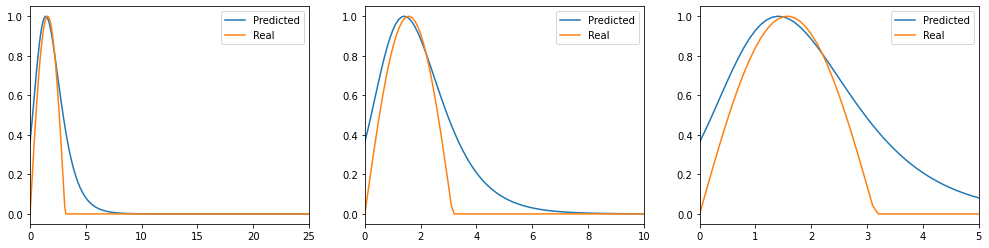

In [425]:
def magic_kernel(x, sigma=1, lengthscale=1, alpha = 1.0):
    d = x

    return sigma * torch.exp(-d / lengthscale) * ((1 + torch.exp(-d)) ** -alpha)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =1):
    d = x**norm
    return b+torch.tanh((d-l)/s)



t =torch.arange(0,200,0.1)+0.000001
val = magic_kernel(t,sigma= 1.0, lengthscale = 1.0, alpha = 5.1)
# val_s = sigmoid((t),l =1.0,s= 0.5,norm =1,b = 1)
values = val

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = sin_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 25)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 5)


(0.0, 5.0)

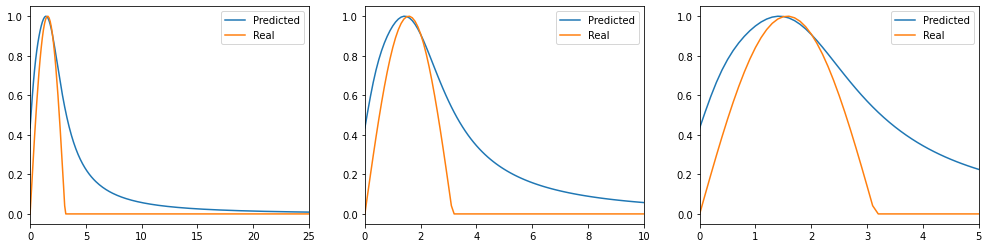

In [177]:
def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=2.1,s=0.1,b = 0.1,norm =1):
    d = x**norm
    return 1.0 + torch.tanh((d - l) / s)

t =torch.arange(0,200,0.1)
val = rational_quadratic_kernel(t,sigma= 1.0, lengthscale = 0.64905889, alpha = 1.0)
val_s = sigmoid((t),l =1.5,s= 1.01,norm =1)
values = val_s*val

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = sin_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 25)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 5)


(0.0, 5.0)

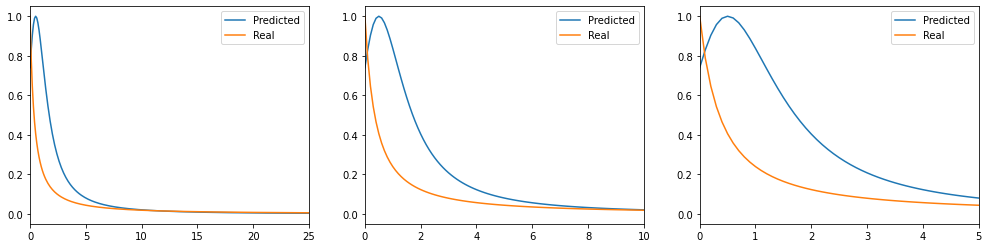

In [425]:
def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =1,scale = 1):
    d = x**norm
    return scale+torch.tanh((d-l)/s)

t =torch.arange(0,200,0.1)
val = rational_quadratic_kernel(t,sigma= 1.0, lengthscale = 1.0, alpha = 1.0)
val_s = sigmoid((t),l =0.3,s= 1.0,norm =1)
values = val_s*val

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = power_law_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 25)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 5)


(0.0, 25.0)

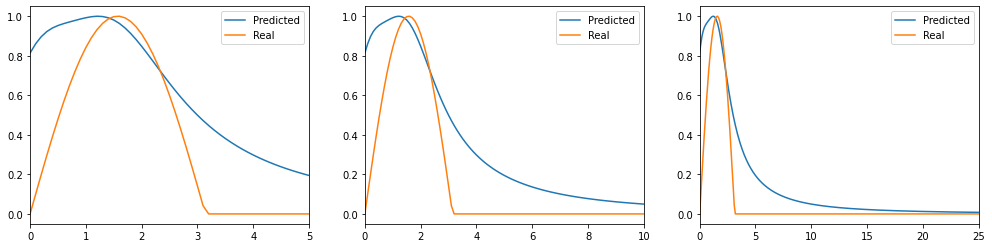

In [206]:
def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =1,scale = 1):
    d = x**norm
    return (b+torch.tanh((d-l)/s))/scale

t =torch.arange(0,200,0.1)
val = rational_quadratic_kernel(t,sigma= 1, lengthscale = 0.8, alpha = 1.0)
val_s = sigmoid((t),l =1.4,s=0.9,norm =1,scale = 2.5,b = 1.2)
values = val_s*val
# values = torch.softmax(values,-1)

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = sin_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 5)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 25)


(0.0, 25.0)

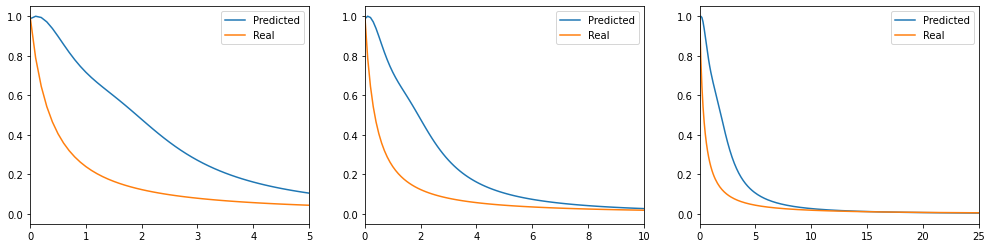

In [207]:
def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =1,scale = 1):
    d = x**norm
    return (b+torch.tanh((d-l)/s))/scale

t =torch.arange(0,200,0.1)
val = rational_quadratic_kernel(t,sigma= 1, lengthscale = 0.8, alpha = 1.0)
val_s = sigmoid((t),l =1.4,s=0.9,norm =1,scale = 2.5,b = 1.7)
values = val_s*val
# values = torch.softmax(values,-1)

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = power_law_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 5)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 25)


(0.0, 25.0)

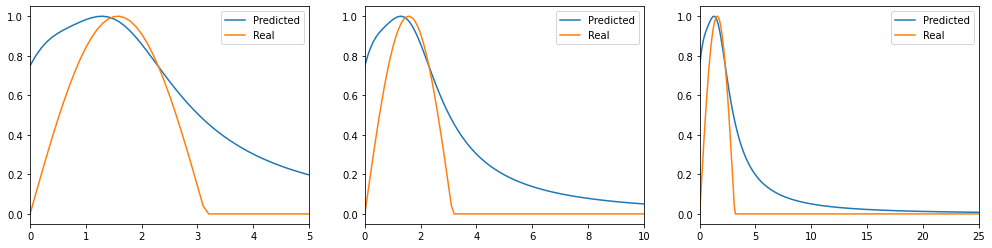

In [210]:
def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =1,scale = 1):
    d = x**norm
    return (b+torch.tanh((d-l)/s))/scale

t =torch.arange(0,200,0.1)
val = rational_quadratic_kernel(t,sigma= 1, lengthscale = 0.8, alpha = 1.0)
val_s = sigmoid((t),l =1.4,s=0.9,norm =1,scale = 2.5,b = 1.17)
values = val_s*val
# values = torch.softmax(values,-1)

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = sin_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 5)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 25)


(0.0, 25.0)

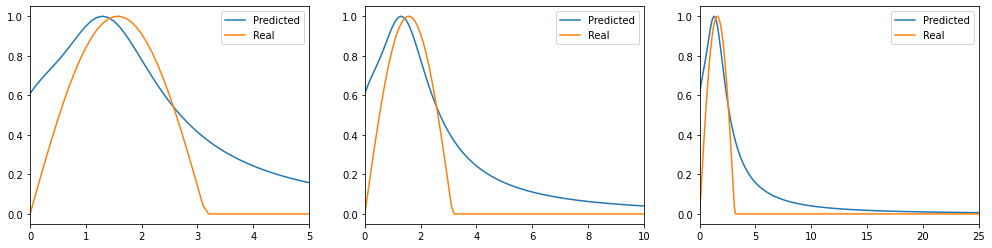

In [244]:
def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =1,scale = 1):
    d = x**norm
    return (b+torch.tanh((d-l)/s))/scale

t =torch.arange(0,200,0.1)
val = rational_quadratic_kernel(t,sigma= 1, lengthscale = 0.8, alpha = 1.0)
val_s = sigmoid((t),l =1.2,s=0.7,norm =1,scale = 1.0,b = 1.2)
values = val_s*val
# values = torch.softmax(values,-1)

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = sin_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 5)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 25)


(0.0, 25.0)

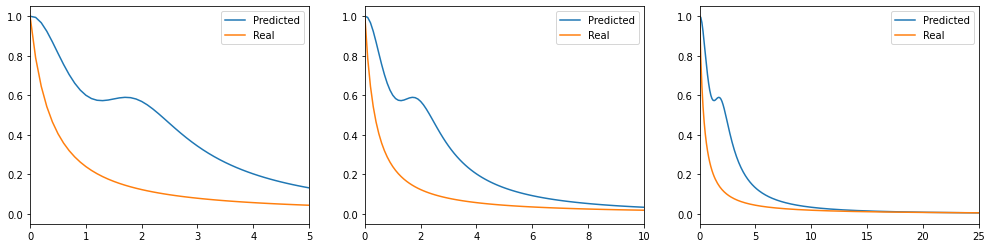

In [249]:
def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =1,scale = 1):
    d = x**norm
    return (b+torch.tanh((d-l)/s))/scale

t =torch.arange(0,200,0.1)
val = rational_quadratic_kernel(t,sigma= 1, lengthscale = 0.8, alpha = 1.0)
val_s = sigmoid((t),l =1.66,s=0.64,norm =1,scale = 1.0,b = 1.6)
values = val_s*val
# values = torch.softmax(values,-1)

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = power_law_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


for ax in axes:
    ax.plot(t,values,label='Predicted')
    ax.plot(t,real_values,label='Real')
    ax.legend()
    
axes[0].set_xlim(0, 5)
axes[1].set_xlim(0, 10)
axes[2].set_xlim(0, 25)


In [ ]:
seq_1

e1, e2, e3 


